<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-EVA4/blob/master/EVA4_Session4_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#A future statement is a directive to the compiler that a particular module should be compiled using syntax or semantics that will be available in a specified future release of Python.
from __future__ import print_function

# torch is the main module that holds all the things you need for Tensor computation.
import torch

# nn module provides many classes and functions to build neural networks.
# models, all kinds of layers, activation functions, parameter classes, etc
import torch.nn as nn

# functional api such as relu
import torch.nn.functional as F

# it offers all the optimizers like SGD, ADAM
import torch.optim as optim

#Torchvision is a package in the PyTorch library containing computer-vision models, datasets, and image transformations
from torchvision import datasets, transforms

#Matplotlib for graphs.
import matplotlib.pyplot as plt


In [0]:
# Build the neural network, expand on top of nn.Module
# All network classes in PyTorch expand on the base class: nn.Module. 
# It packs all the basics: weights, biases, forward method and also some utility attributes and methods like .parameters() and zero_grad()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # define layer: n_channels=1, out_channels=32, kernel_size=3
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)   #input: 1X28X28,    Output: 32X28X28,   RF:3X3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  #input: 32X28X28,   Output: 64X28X28,   RF:5X5

        #kernel_size=2, stride=2
        self.pool1 = nn.MaxPool2d(2, 2)               #input: 64X28X28,   Output: 64X14X14,   RF:6X6      (S2: RF:10X10)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) #input: 64X14X14,   Output: 128X14X14,  RF:10X10    (S2: RF:12X12)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)#input: 128X14X14,  Output: 256X14X14,  RF:14X14    (S2: RF:14X14)
        #self.conv2_drop = nn.Dropout2d
        self.pool2 = nn.MaxPool2d(2, 2)               #input: 256X14X14,  Output: 256X7X7,    RF:16X16    (S2: RF:28X28)
        self.conv5 = nn.Conv2d(256, 512, 3)           #input: 256X7X7,    Output: 512X5X5,    RF:24X24    (S2: RF:30X30)
        self.conv6 = nn.Conv2d(512, 1024, 3)          #input: 512X5X5,    Output: 1024X3X3,   RF:32X32    (S2: RF:32X32)
        self.conv7 = nn.Conv2d(1024, 10, 3)           #input: 1024X3X3,   Output: 10X1X1,     RF:40X40    (S2: RF:34X34)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = self.conv7(x)
        
        # flatten the tensor so it can be passed to the dense layer afterward
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [10]:
#A way to summarise the model. Summary is textual. Provides- Layer and order of the model, output shape of each layer, total number of parameter in each layer and in the model. 
from torchsummary import summary

#To check if CUDA is available and if system supports. CUDA allows programme to utilize GPUs for computation.
use_cuda = torch.cuda.is_available()

#Device- Object representing the object on which tensor is or will be allocated.
device = torch.device("cuda" if use_cuda else "cpu")

#Moves model weights to GPUs.
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
torch.manual_seed(1) # seeding is added so that everytime we run this notebook we get the same result
#How many data to be passed at a time to the model.
batch_size = 128

#num_workers > 1 to use subprocesses to asynchronously load data. pinned RAM (via pin_memory) to speed up RAM to GPU transfers.
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Description for datasets.MNIST
# followed link: https://www.aiworkbox.com/lessons/load-mnist-dataset-from-pytorch-torchvision
# root: root parameter is to define where to save the data. here: '../data'
# The train parameter is set to true because we are initializing the MNIST training dataset.
# The download parameter is set to true because we want to download it if it’s not already present in our data folder.
# The transform parameter is used for image manipulation transforms. here we are normalizing the training dataset
# transforms.ToTensor to turn images into Tensor so we can directly use it with our network

# created two folder with name "raw" and "processed"
# ../data/MNIST/processed/ ( 2 files(test.pt, training.pt) are generated after processing)
# ../data/MNIST/raw/ (8 files are downloded)

# DataLoader: it can load multiple samples parallelly using torch.multiprocessing workers
# 0.1307 = Global mean and 0.3081 = Standard Deviation of the MNIST dataset. We'll take them as a given for the normalization.
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# The train parameter is set to false because we want test set, not the train set.
# TBD: download=True. If true, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.
# TBD: why shuffle=True? - To shuffle the dataset so that model generalises better.
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [0]:
# Using tqdm to show the progress bar. Pass any iterable as argument to tqdm.
from tqdm import tqdm
#An epoch is a measure of the number of times all training data is used once to update the parameters.
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        # we need to manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients.
        optimizer.zero_grad()
        #produce the output of our network (forward pass).
        output = model(data)
        #nll_loss - Negative log likelihood loss.  
        #Specify the reduction to apply on the output. By default-'mean'. The sum of the output will be divided by the number of elements in the output.
        loss = F.nll_loss(output, target)
        #Collect a new set of gradients.
        loss.backward()
        #Gradients propagated back into each of the network's parameters.
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
        
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    test_loss /= len(test_loader.dataset)    
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    accuracy_hist.append(round(100. * correct / len(test_loader.dataset),2))    
    print('Accuracy score history:',accuracy_hist)

    if (epoch == (epoch_lim-1)):
      plt.figure(figsize=(12,12))
      ax = plt.gca()
      ax.set_xlim([1, epoch + 2])
      plt.ylabel('Accuracy')
      plt.plot(range(1, epoch + 1), accuracy_hist[:epoch+1], 'b', label='Test Accuracy')
      ax.grid(linestyle='-.')
      plt.legend()
      plt.show()

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0700, Accuracy: 9784/10000 (97.84%)

Accuracy score history: [97.84]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9862/10000 (98.62%)

Accuracy score history: [97.84, 98.62]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9895/10000 (98.95%)

Accuracy score history: [97.84, 98.62, 98.95]


loss=0.07598172873258591 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 25.23it/s]



Test set: Average loss: 0.0276, Accuracy: 9912/10000 (99.12%)

Accuracy score history: [97.84, 98.62, 98.95, 99.12]


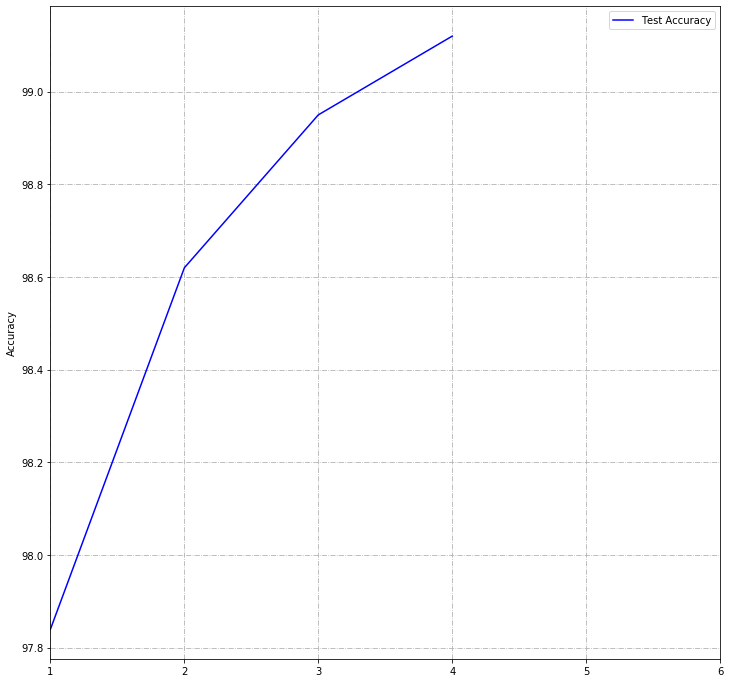

In [15]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epoch_lim = 5
accuracy_hist = []
for epoch in range(1, epoch_lim):
    
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)